In [2]:
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from easydict import EasyDict as edict

In [12]:
config = edict()
config.channel_mult = [1, 2, 3, 4]
config.model_channels = 16
config.attn_resolutions = [0,]
config.layers_per_block = 1
config.num_fid_sample = 5000
config.fid_batch_size = 1024
config.channels = 1
config.img_size = 32
config.device = "cuda"
config.sigma_min = 0.002
config.sigma_max = 80.0
config.rho = 7.0 
config.sigma_data = 0.5

In [14]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
from train_edm import edm_sampler
from train_edm import EDM
from train_edm import create_model

def load_create_edm(config, model_path):
    # model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth"
    unet = create_model(config)
    edm = EDM(model=unet, cfg=config)
    checkpoint = torch.load(model_path, map_location=device)
    # logger.info(f"loaded model: {model_name}")
    edm.model.load_state_dict(checkpoint)
    for param in edm.model.parameters():
        param.requires_grad = False
    edm.model.eval()
    return edm

model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_gabor_prime_20240130-2251/checkpoints/ema_5000.pth"
unet = create_model(config)
edm = EDM(model=unet, cfg=config)
checkpoint = torch.load(model_path, map_location=device)
# logger.info(f"loaded model: {model_name}")
edm.model.load_state_dict(checkpoint)
for param in edm.model.parameters():
    param.requires_grad = False
edm.model.eval();

In [76]:
epoch = 500
model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_gabor_prime_20240130-2251/checkpoints/ema_{epoch}.pth"
edm = load_create_edm(config, model_path)


In [16]:
import torchvision
class CachedImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super(CachedImageFolder, self).__init__(root, transform=transform, target_transform=target_transform)
        self.cache = {}

    def __getitem__(self, index):
        """
        Overriding the method to include caching.
        """
        path, target = self.samples[index]
        if path not in self.cache:
            # Load and transform the image if it's not in cache
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)
            
            # Save to cache
            self.cache[path] = (sample, target)
        else:
            # Retrieve from cache
            sample, target = self.cache[path]

        return sample, target

In [18]:
dataset_root = "/n/home12/binxuwang/Datasets/gabor_prime"
img_dataset = CachedImageFolder(root=dataset_root, 
                                            transform=torchvision.transforms.Compose(
                                                    [torchvision.transforms.Resize(config.img_size),
                                                    torchvision.transforms.Grayscale(num_output_channels=1),
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize((0.5,), (0.5,))]
                                            ),)

In [53]:
Xtsr = torch.stack([img_dataset[i][0] for i in range(len(img_dataset))], dim=0)
Xmat = Xtsr.view(Xtsr.shape[0], -1).to(device).double()
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T)
imshape = Xtsr.shape[1:]

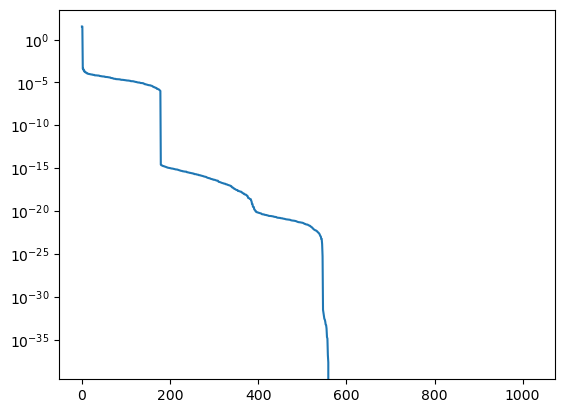

In [50]:
# eigen decomposition
eigval, eigvec = torch.linalg.eigh(Xcov)
eigval = eigval.flip(dims=(0,))
eigvec = eigvec.flip(dims=(1,))
plt.semilogy(eigval.cpu())

In [33]:
sample_id = [i for i, sample in enumerate(img_dataset.samples) if 'gabor_prime_90' in sample[0]]
print(sample_id)


[175]


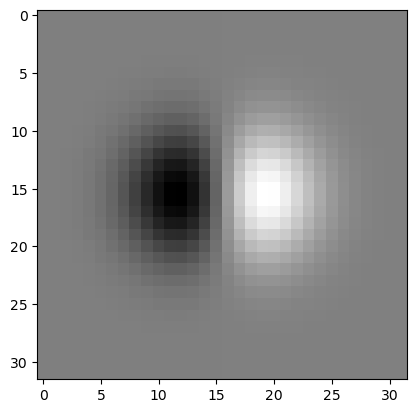

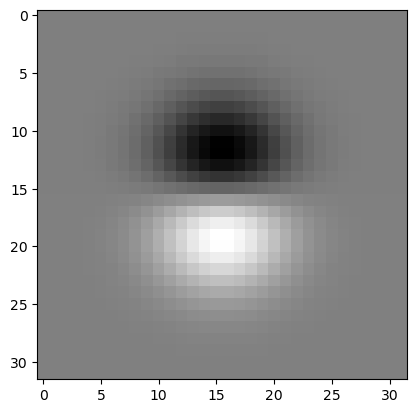

In [34]:
import matplotlib.pyplot as plt
plt.imshow(img_dataset[0][0][0], cmap='gray')
plt.show()
plt.imshow(img_dataset[175][0][0], cmap='gray')
plt.show()

In [56]:
class CoordSystem:
    
    def __init__(self, basis1, basis2, origin=None):
        # Ensure the basis vectors are normalized and orthogonal
        # if origin is None:
        #     origin = torch.zeros_like(basis1)
        self.reference = origin
        self.basis1 = basis1 / torch.norm(basis1)
        self.basis2 = basis2 / torch.norm(basis2)
        self.basis_matrix = torch.stack([self.basis1, self.basis2], dim=0)

    def project_vector(self, vectors):
        # Project a vector onto the basis using matrix algebra
        return (vectors @ self.basis_matrix.T)

    def ortho_project_vector(self, vectors):
        # Project a vector onto the perpendicular space of the basis using matrix algebra
        return vectors - (vectors @ self.basis_matrix.to(vectors.dtype).T) @ self.basis_matrix.to(vectors.dtype)
    
    def project_points(self, points):
        # Project a set of points onto the basis
        return (points - self.reference) @ self.basis_matrix.T

    def generate_grid(self, x_range=(0, 1), y_range=(0, 1), grid_nums=(10, 10)):
        # Generate a grid of points in the basis
        grid_vecs = []
        for ti in torch.linspace(x_range[0], x_range[1], grid_nums[0]):
            for tj in torch.linspace(y_range[0], y_range[1], grid_nums[1]):
                grid_vecs.append(ti * self.basis1 + tj * self.basis2 + self.reference)
        return torch.stack(grid_vecs)

def orthogonal_grid_torch(x1, x2, x3, grid_nums=(10, 10), 
                          x_range=(0, 1), y_range=(0, 1)):
    # Step 1: Find the Basis Vectors
    v1 = x2 - x1
    v = x3 - x1
    # Orthogonalize v with respect to v1 using the Gram-Schmidt process
    proj_v1_v = torch.dot(v, v1) / torch.dot(v1, v1) * v1
    v2 = v - proj_v1_v
    v1_norm = torch.norm(v1)
    v2_norm = torch.norm(v2)
    # Step 2: Normalize the Basis Vectors
    v1_normalized = v1 / v1_norm
    v2_normalized = v2 / v2_norm
    coordsys = CoordSystem(v1_normalized, v2_normalized, origin=x1)
    # Step 3: Create the Grid Points
    grid_vecs = []
    norm_coords = []
    plane_coords = []
    for ti in torch.linspace(x_range[0], x_range[1], grid_nums[0]):
        for tj in torch.linspace(y_range[0], y_range[1], grid_nums[1]):
            # Scaling factors for v1 and v2
            scale_v1 = ti * v1_norm
            scale_v2 = tj * v2_norm
            # Generate the grid point
            grid_vec = x1 + scale_v1 * v1_normalized + scale_v2 * v2_normalized
            grid_vecs.append(grid_vec)
            norm_coords.append([ti, tj])
            plane_coords.append([scale_v1, scale_v2])
    return torch.stack(grid_vecs), \
            torch.tensor(norm_coords), \
            torch.tensor(plane_coords), coordsys

In [59]:
Xvec0 = Xmat[0]
Xvec90 = Xmat[175]
grid_vecs, norm_coords, plane_coords, coordsys = orthogonal_grid_torch(Xmean, Xvec0, Xvec90, grid_nums=(51, 51), 
                          x_range=(-1.5, 1.5), y_range=(-1.5, 1.5))

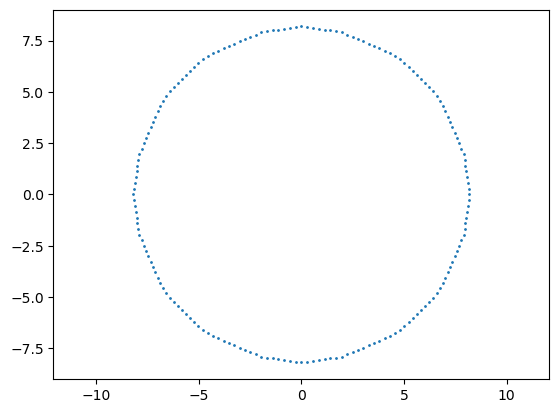

In [63]:
training_pnts = coordsys.project_points(Xmat).cpu().numpy()
plt.scatter(training_pnts[:, 0], training_pnts[:, 1], s=1)
plt.axis('equal')
plt.show()

In [81]:
# Compute score on the grid points
epoch = 500
model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_gabor_prime_20240130-2251/checkpoints/ema_{epoch}.pth"
edm = load_create_edm(config, model_path)

sigma = .1
edm_Dt = edm(grid_vecs.view(-1, *imshape), 
             torch.tensor(sigma), None, use_ema=False).detach()
score_edm = (edm_Dt.view(grid_vecs.shape) - grid_vecs) / (sigma**2)
name = f"EDM_ep{epoch}"
vec_proj = coordsys.project_vector(score_edm).cpu().numpy()
vec_ortho = coordsys.ortho_project_vector(score_edm)
ortho_norm = torch.norm(vec_ortho, dim=-1).cpu()
figh, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].invert_yaxis()
axs[0].quiver(plane_coords[:, 1], plane_coords[:, 0], vec_proj[:, 1], vec_proj[:, 0], angles='xy')
# axs[i].scatter(anchor_proj[:, 1], anchor_proj[:, 0], color='r', marker='x')
axs[0].scatter(training_pnts[:, 1], training_pnts[:, 0], s=10, c="r")
axs[0].set_aspect('equal')
axs[0].set_title(name+f" score vector field\nsigma={sigma:f}")
im = axs[1].imshow(ortho_norm.view(51, 51), cmap='viridis')
plt.colorbar(im, ax=axs[1])
axs[1].set_title(name+f" orthogonal score magnitude\nsigma={sigma:f}")
plt.show()

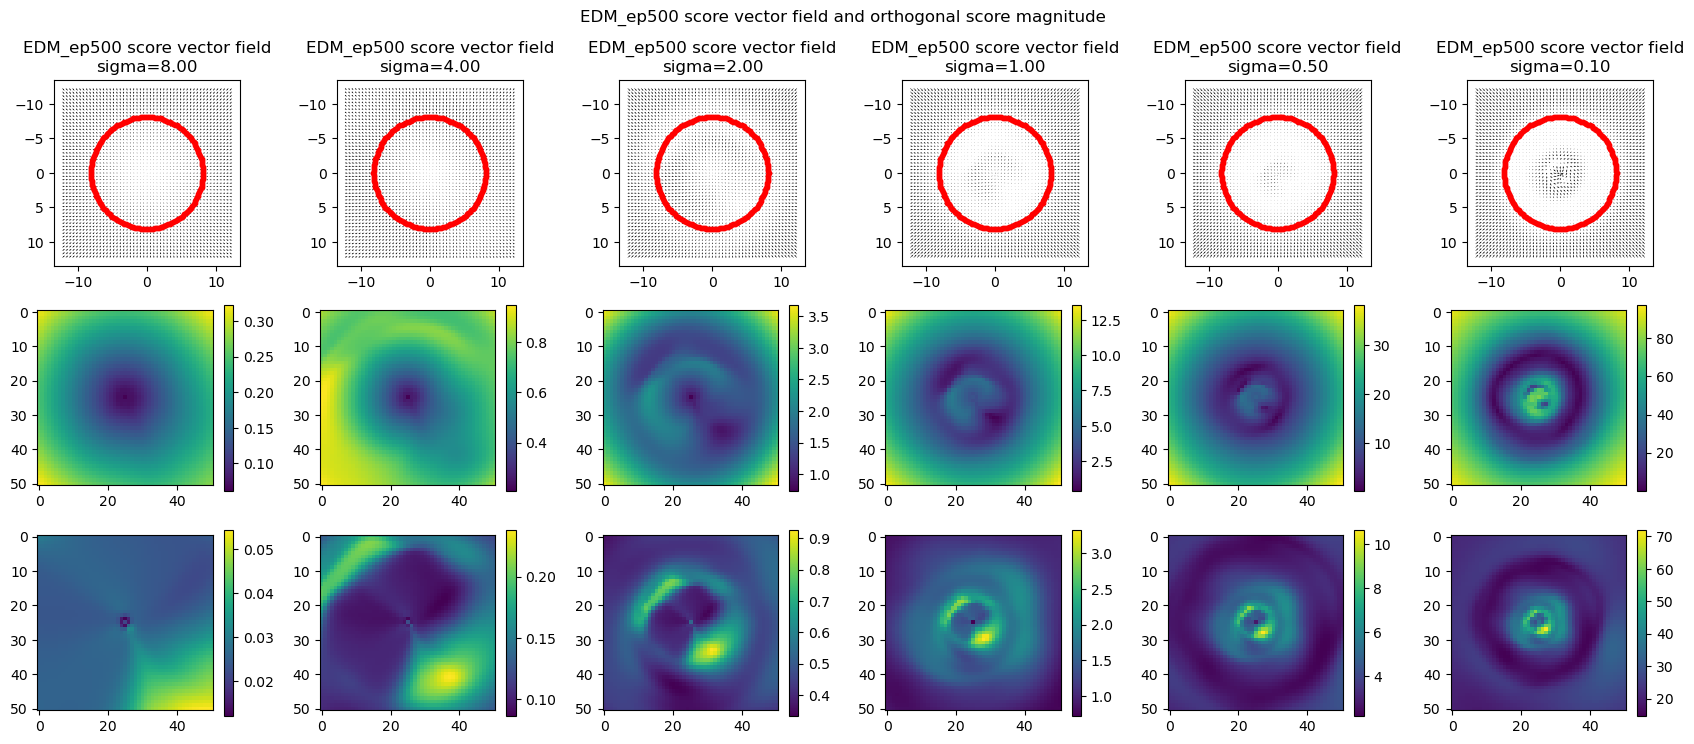

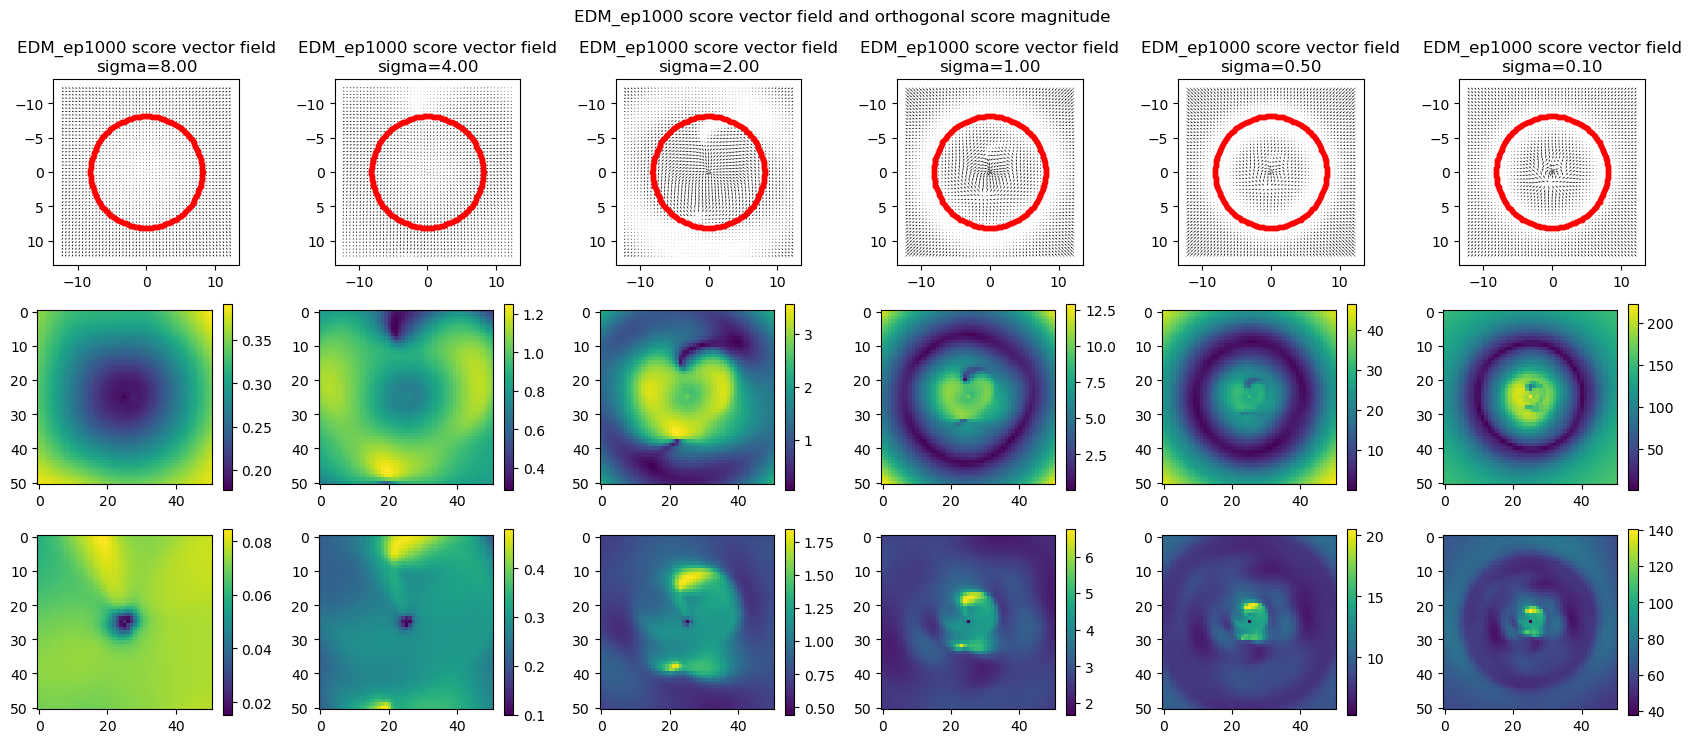

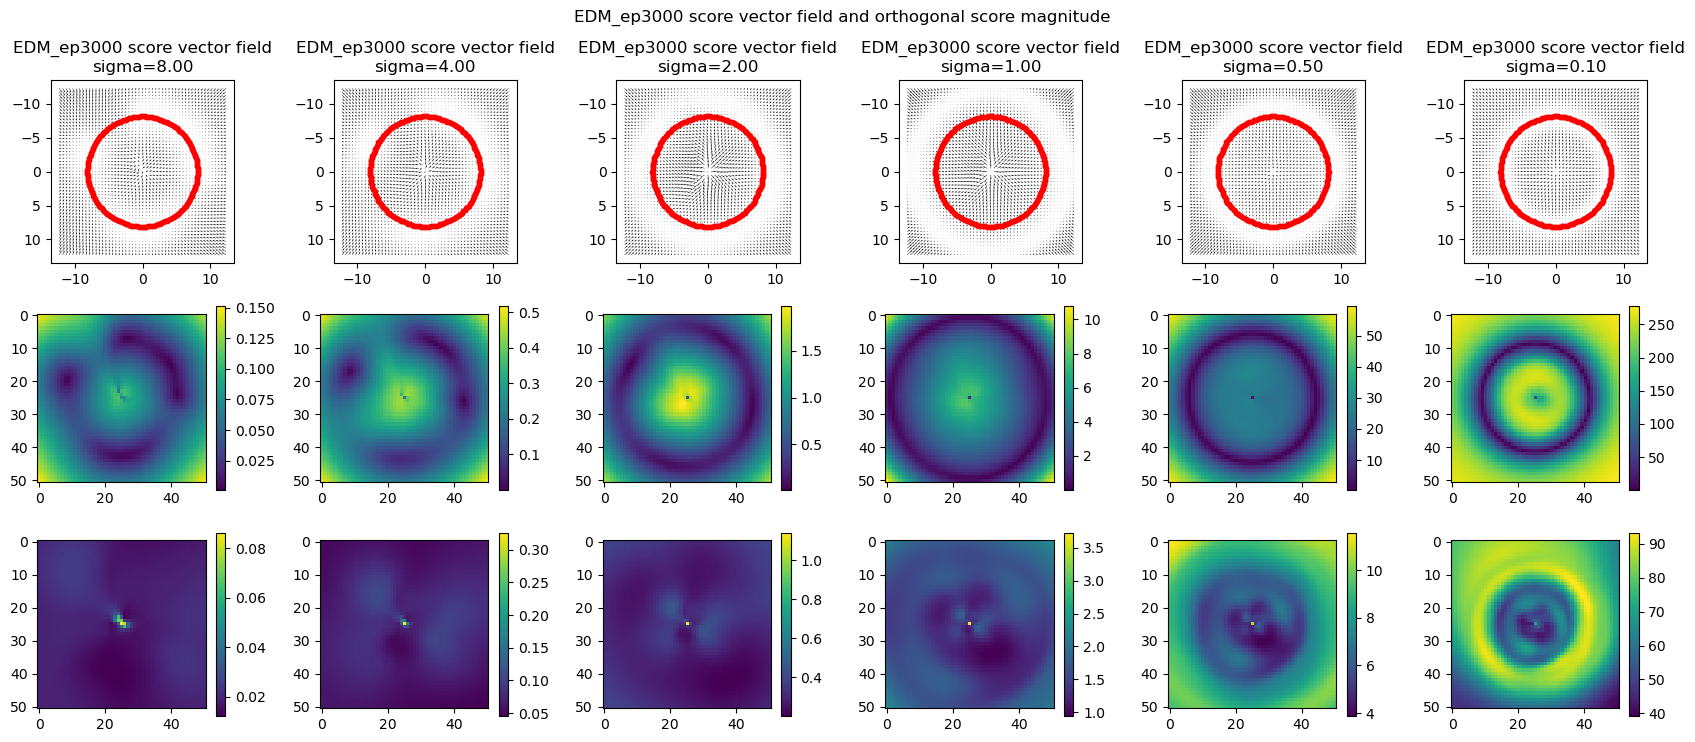

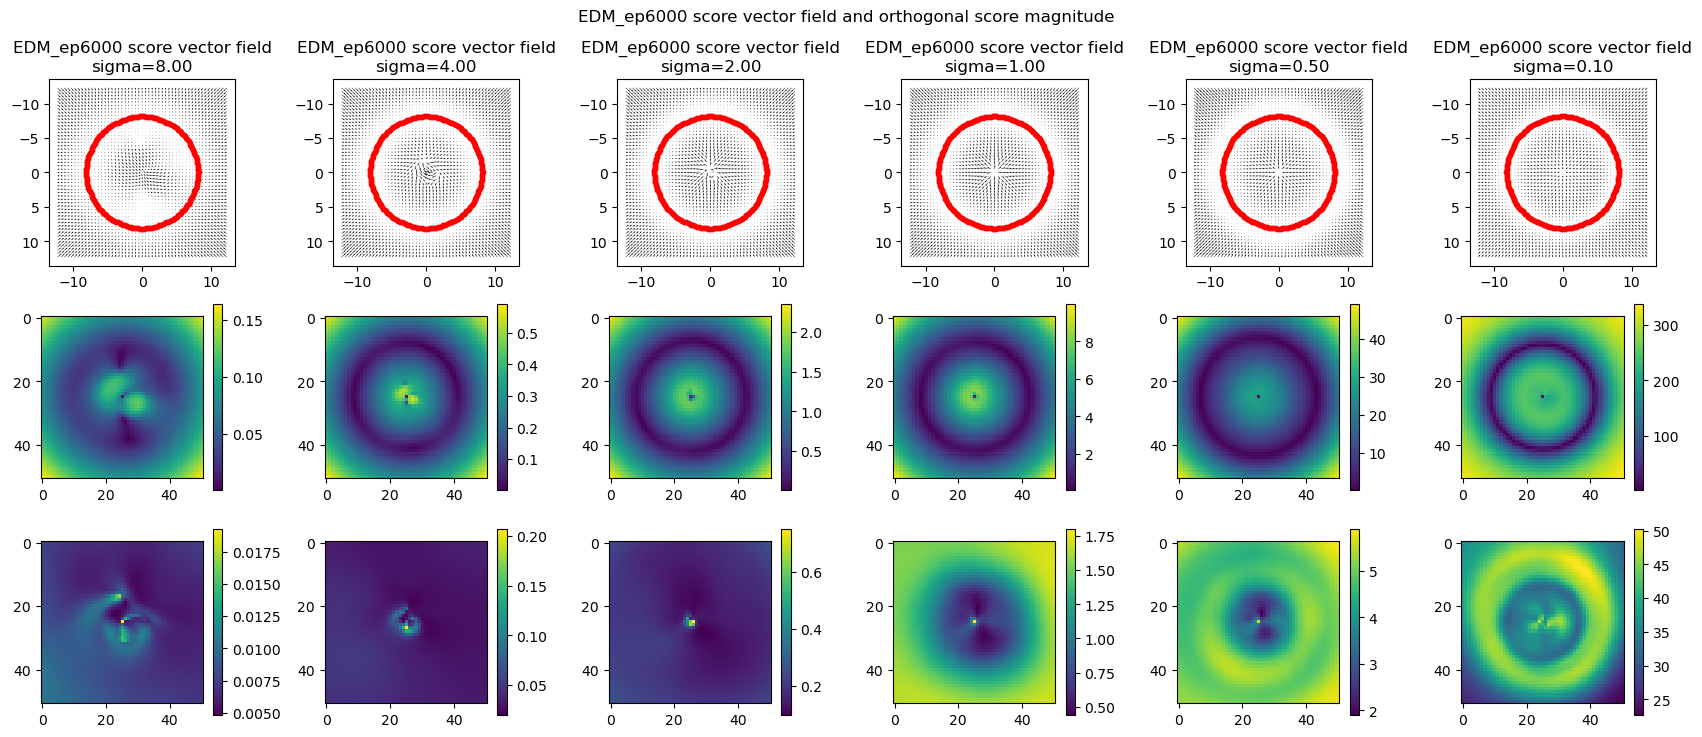

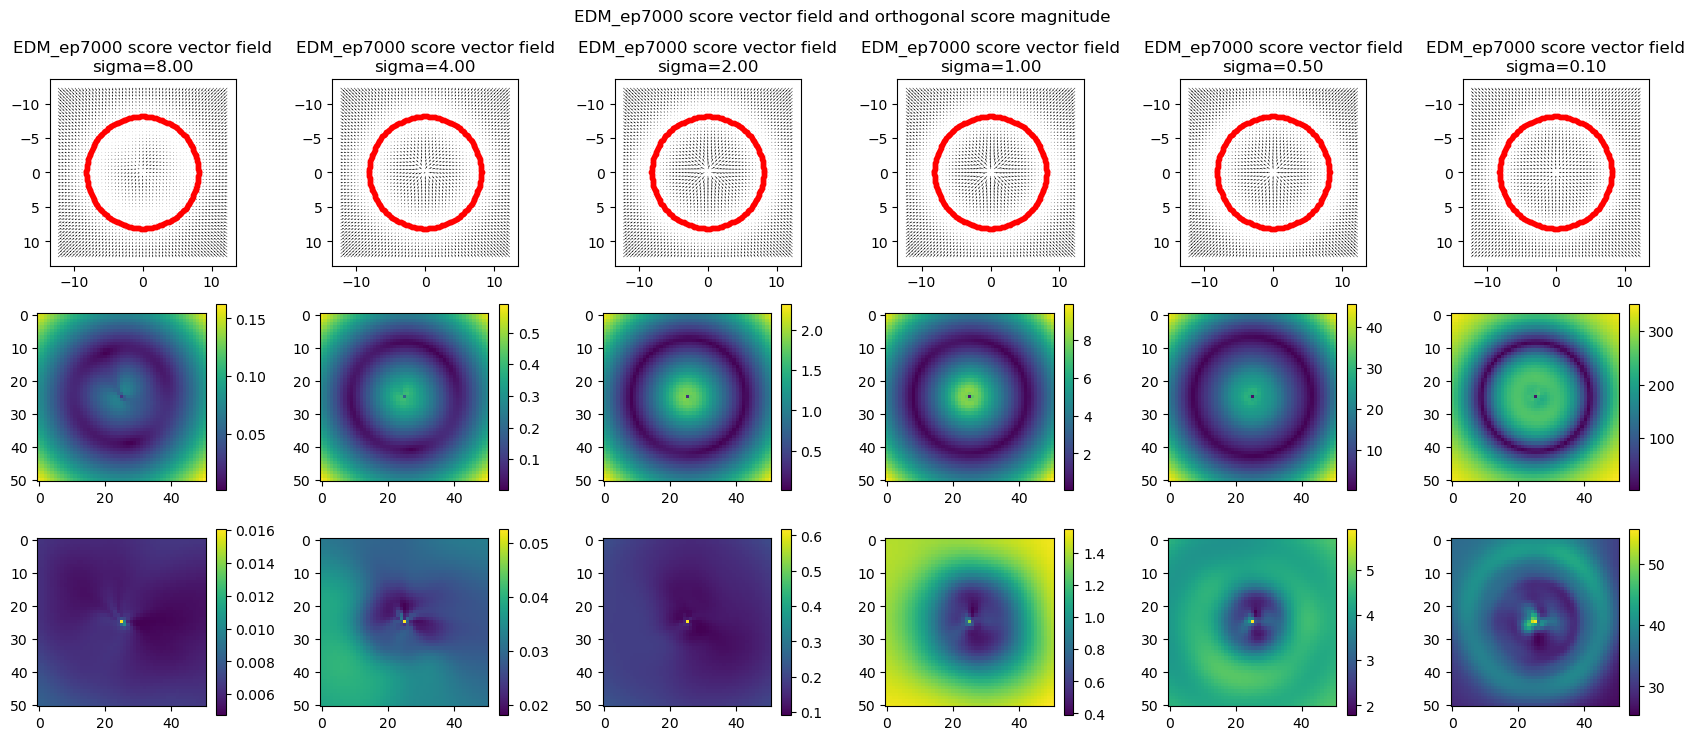

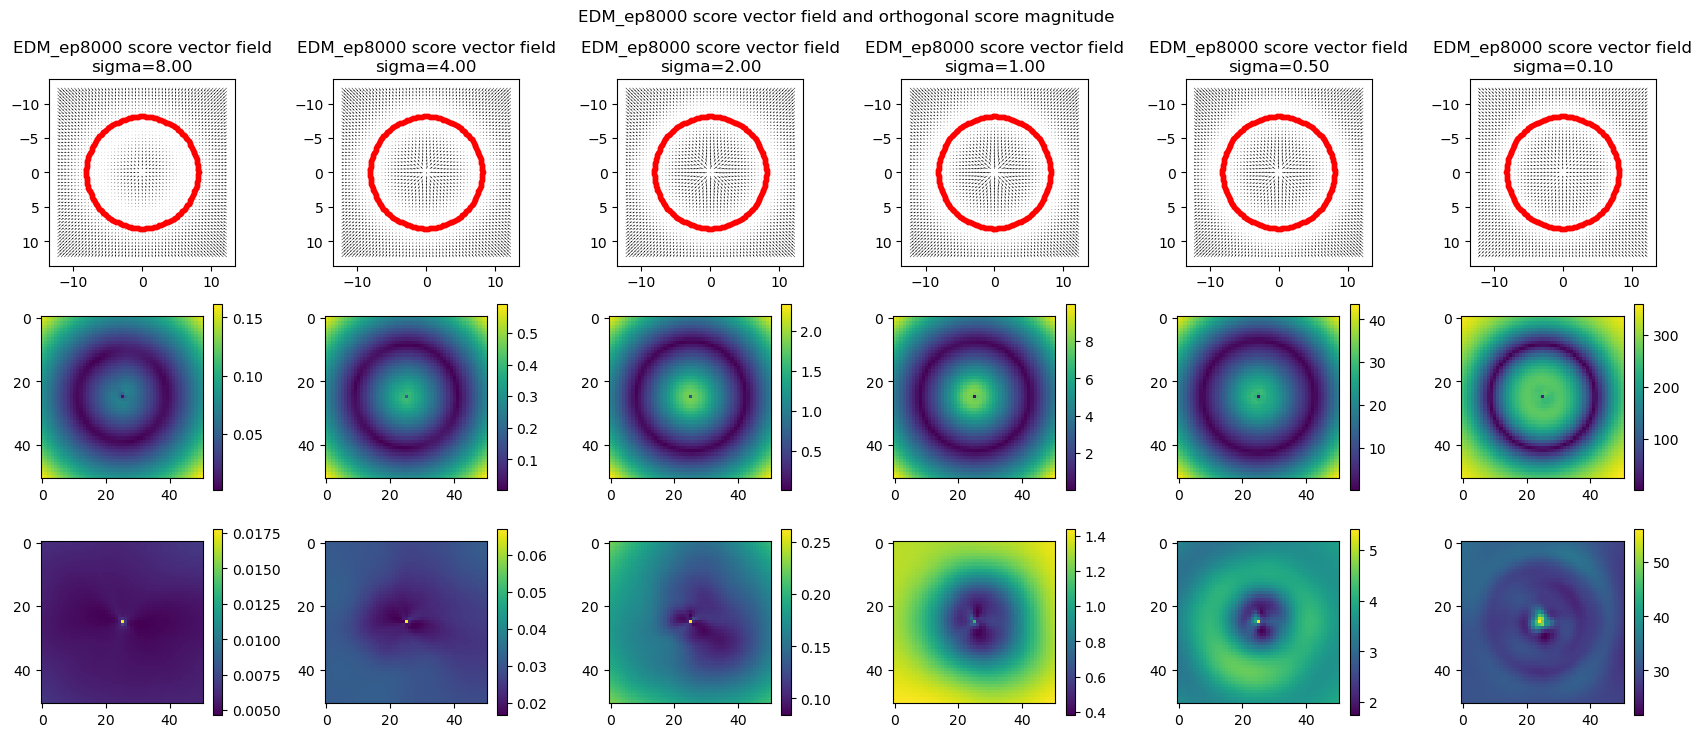

In [93]:
# Compute score on the grid points
for epoch in [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]:
    model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_gabor_prime_20240130-2251/checkpoints/ema_{epoch}.pth"
    edm = load_create_edm(config, model_path)

    figh, axs = plt.subplots(3, 6, figsize=(17, 7.5))
    for i, sigma in enumerate(reversed([0.1, 0.5, 1.0, 2.0, 4.0, 8.0])):
        edm_Dt = edm(grid_vecs.view(-1, *imshape), 
                torch.tensor(sigma), None, use_ema=False).detach()
        score_edm = (edm_Dt.view(grid_vecs.shape) - grid_vecs) / (sigma**2)
        name = f"EDM_ep{epoch}"
        vec_proj = coordsys.project_vector(score_edm).cpu()
        vec_ortho = coordsys.ortho_project_vector(score_edm)
        ortho_norm = torch.norm(vec_ortho, dim=-1).cpu()
        proj_norm = torch.norm(vec_proj, dim=-1).cpu()
        axs[0, i].invert_yaxis()
        axs[0, i].quiver(plane_coords[:, 1], plane_coords[:, 0], vec_proj[:, 1], vec_proj[:, 0], angles='xy')
        # axs[i].scatter(anchor_proj[:, 1], anchor_proj[:, 0], color='r', marker='x')
        axs[0, i].scatter(training_pnts[:, 1], training_pnts[:, 0], s=10, c="r")
        axs[0, i].set_aspect('equal')
        axs[0, i].set_title(name+f" score vector field\nsigma={sigma:.2f}")
        im1 = axs[1, i].imshow(proj_norm.view(51, 51), cmap='viridis')
        plt.colorbar(im1, )
        im2 = axs[2, i].imshow(ortho_norm.view(51, 51), cmap='viridis')
        plt.colorbar(im2, )
        # axs[1, i].set_title(name+f" orthogonal score magnitude\nsigma={sigma:2f}")
    plt.suptitle(name+f" score vector field and orthogonal score magnitude")
    plt.tight_layout()
    plt.show()